### Setting up Flickr30K Dataset from Kaggle

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [03:12<00:00, 26.4MB/s]
100% 8.16G/8.16G [03:12<00:00, 45.5MB/s]


In [0]:
!unzip flickr-image-dataset.zip
!rm -rf flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5362687336.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Library Imports

In [0]:
import cv2
import nltk
import keras
import pickle
import numpy as np
import collections
from time import time
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras import layers
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

### Data Collection

In [0]:
base_url = './drive/My Drive/Assistive Vision/'

In [0]:
# Read Text Captions
def readFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [0]:
captions = readFile('./flickr30k_images/results.csv')
captions = captions.split('\n')[1:]
print(len(captions))
print(captions[0])

In [0]:
# Dictionary to map each Image with its List of Captions
descriptions = {}
train = []
for ix in captions:
    idata = ix.split('|')
    img = idata[0].split('.')[0]
    if img == '':
      continue
    if descriptions.get(img) is None:
      descriptions[img] = []
      train.append(img)
    if len(idata) == 3:
      descriptions[img].append(idata[2])
    else:
      print(ix)

In [0]:
descriptions['537230454']

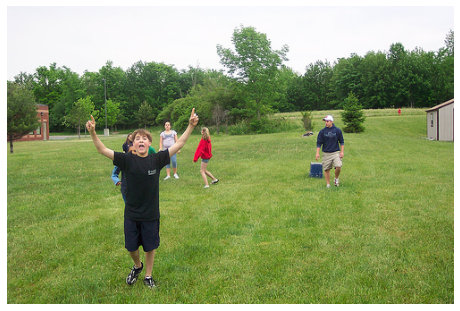

In [0]:
plt.style.use('seaborn')
IMG_PATH = './flickr30k_images/flickr30k_images/'
img = cv2.imread(IMG_PATH+'537230454.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)
plt.show()

### Data Cleaning

In [0]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ',sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = ' '.join(sentence)
    return sentence

In [0]:
# Cleaning all captions
for img,cap_list in descriptions.items():
    for i in range(len(cap_list)):
        cap_list[i] = clean_text(cap_list[i])

In [0]:
descriptions['537230454']

['boy is standing on grassy field with his arms raised while others are standing behind him',
 'boy in black waves his arms while other people are behind him on field',
 'young boy poses in grassy field as onlookers stand in the background',
 'boy is making the victory sign with both hands',
 'people are standing in field']

In [0]:
# Save the cleaned data in file
with open(base_url+'descriptions.pkl','wb') as f:
    pickle.dump(descriptions,f)

### Building The Vocabulary

In [0]:
descriptions = None
with open(base_url+'descriptions.pkl','rb') as f:
    descriptions = pickle.load(f)
print(type(descriptions))
descriptions['537230454']

<class 'dict'>


['boy is standing on grassy field with his arms raised while others are standing behind him',
 'boy in black waves his arms while other people are behind him on field',
 'young boy poses in grassy field as onlookers stand in the background',
 'boy is making the victory sign with both hands',
 'people are standing in field']

In [0]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print('Vocabulary size : {}'.format(len(vocab)))

Vocabulary size : 18054


In [0]:
# Total no of words across all sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(word) for sent in descriptions[key] for word in sent.split()]
print('Total no of words : {}'.format(len(total_words)))

Total no of words : 1679075


In [0]:
# Find the count of each word
counter = collections.Counter(total_words)
freq_count = dict(counter)
print(len(freq_count.keys()))

18054


In [0]:
# Filter words from vocab acc to certain threshold frequency
sorted_freq_count = sorted(freq_count.items(),reverse=True,key=lambda x:x[1])
threshold = 3
sorted_freq_count = [x for x in sorted_freq_count if x[1]>threshold]
total_unique_words = [x[0] for x in sorted_freq_count]
print(len(total_unique_words))

8431


### Preparing Data for Training

In [0]:
# Add <BEGIN> and <END> to the data
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        train_descriptions[img_id].append('<BEGIN> '+cap+' <END>')

In [0]:
with open(base_url+"/features/encoded_captions.pkl",'wb') as f:
    pickle.dump(train_descriptions,f)
train_descriptions['537230454']

['<BEGIN> boy is standing on grassy field with his arms raised while others are standing behind him <END>',
 '<BEGIN> boy in black waves his arms while other people are behind him on field <END>',
 '<BEGIN> young boy poses in grassy field as onlookers stand in the background <END>',
 '<BEGIN> boy is making the victory sign with both hands <END>',
 '<BEGIN> people are standing in field <END>']

###  Image Feature Extraction ( InceptionV3 Model )

In [0]:
model = tf.keras.applications.InceptionV3(weights='imagenet',input_shape=(299,299,3))
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [0]:
new_model = tf.keras.Model(model.input,model.layers[-2].output)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [0]:
new_model.save(base_url+"features/feature_extractor.h5")

In [0]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def encode_image(img):
    img = preprocess_img(img)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

### Encoding Training Images

In [0]:
start = time()
encoded_img = {}
for ix,img_id in enumerate(train):
    img_path = IMG_PATH+img_id+'.jpg'
    encoded_img[img_id] = encode_image(img_path)
    if ix%1000 == 0:
        print('Train Encoding in Progress, Time Step : %d'%ix)
end = time()
print('Total Time Taken : ',end-start)

Train Encoding in Progress, Time Step : 0
Train Encoding in Progress, Time Step : 1000
Train Encoding in Progress, Time Step : 2000
Train Encoding in Progress, Time Step : 3000
Train Encoding in Progress, Time Step : 4000
Train Encoding in Progress, Time Step : 5000
Train Encoding in Progress, Time Step : 6000
Train Encoding in Progress, Time Step : 7000
Train Encoding in Progress, Time Step : 8000
Train Encoding in Progress, Time Step : 9000
Train Encoding in Progress, Time Step : 10000
Train Encoding in Progress, Time Step : 11000
Train Encoding in Progress, Time Step : 12000
Train Encoding in Progress, Time Step : 13000
Train Encoding in Progress, Time Step : 14000
Train Encoding in Progress, Time Step : 15000
Train Encoding in Progress, Time Step : 16000
Train Encoding in Progress, Time Step : 17000
Train Encoding in Progress, Time Step : 18000
Train Encoding in Progress, Time Step : 19000
Train Encoding in Progress, Time Step : 20000
Train Encoding in Progress, Time Step : 21000
T

In [0]:
# Store encoded features of training images on disk
with open(base_url+'features/encoded_image_features.pkl','wb') as f:
    pickle.dump(encoded_img,f)

### Preprocessing Captions

In [0]:
# Vocab Size
len(total_unique_words)

8431

In [0]:
word2idx = {}
idx2word = {}
for i,word in enumerate(total_unique_words):
    word2idx[word] = i+1
    idx2word[i+1] = word

word2idx['<BEGIN>'] = 8432
idx2word[8432] = '<BEGIN>'
word2idx['<END>'] = 8433
idx2word[8433] = '<END>'
vocab_size = len(idx2word)+1
print('Vocab Size : %d'%vocab_size)

Vocab Size : 8434


In [0]:
with open(base_url+'features/idx2word.pkl','wb') as f:
    pickle.dump(idx2word,f)
with open(base_url+'features/word2idx.pkl','wb') as f:
    pickle.dump(word2idx,f)

In [0]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
print('Maximum Length of Caption : %d'%max_len)

Maximum Length of Caption : 74


### Data Generator

In [0]:
def data_generator(train_descriptions,encoded_img,word2idx,max_len,batch_size):
    X1,X2,Y = [],[],[]
    n = 0
    while True:
        for key,cap_list in train_descriptions.items():
            n += 1
            img = encoded_img[key]
            for cap in cap_list:
                seq = [word2idx[word] for word in cap.split() if word in word2idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    X1.append(img)
                    X2.append(xi)
                    Y.append(yi)
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(Y)]
                    X1,X2,Y = [],[],[]
                    n = 0

### Word Embeddings

In [0]:
!kaggle datasets download -d watts2/glove6b50dtxt
!unzip glove6b50dtxt.zip
!rm -rf glove6b50dtxt.zip

100% 67.7M/67.7M [00:00<00:00, 88.5MB/s]

Archive:  glove6b50dtxt.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        


In [0]:
f = open('glove.6B.50d.txt',encoding='utf8')
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = embedding
f.close()
with open(base_url+'features/embedding_index.pkl','wb') as f:
    pickle.dump(embedding_index,f)

In [0]:
embedding_dim = 50
def get_embedding_matrix():
    matrix = np.zeros((vocab_size,embedding_dim))
    for word,idx in word2idx.items():
        embed_vector = embedding_index.get(word)
        if embed_vector is not None:
            matrix[idx] = embed_vector
    return matrix

In [0]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(8434, 50)

In [0]:
def get_embedding_matrix():
  matrix = np.zeros((vocab_size,embedding_dim))
  for word,idx in word2idx.items():
    embed_vector = embedding_index.get(word)
    if embed_vector is not None:
      matrix[idx] = embed_vector
  return matrix
  
embedding_matrix = get_embedding_matrix()

### Sequence Model for Image & Captions

In [0]:
# Image Features as Input
inp_img = Input(shape=(2048,))
inp_img1 = Dropout(0.03)(inp_img)
inp_img2 = Dense(256,activation='relu')(inp_img1)
# Captions as Input
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# Combined Model
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)
model = keras.Model(inputs=[inp_img,inp_cap],outputs=outputs)
# Initializing The Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
# Compiling The Model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           (None, 74)           0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 74, 50)       421700      input_42[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 2048)         0           input_41[0][0]                   
____________________________________________________________________________________________

In [0]:
epochs = 20
batch_size = 128
steps = len(train_descriptions)//batch_size
generator = data_generator(train_descriptions,encoded_img,word2idx,max_len,batch_size)
hist = model.fit_generator(generator,epochs=20,steps_per_epoch=steps)
model.save(base_url+'features/model.h5')

Epoch 1/20
248/248 [==============================] - 404s 2s/step - loss: 5.4123
Epoch 2/20
248/248 [==============================] - 402s 2s/step - loss: 4.3920
Epoch 3/20
248/248 [==============================] - 401s 2s/step - loss: 4.0594
Epoch 4/20
248/248 [==============================] - 401s 2s/step - loss: 3.8776
Epoch 5/20
248/248 [==============================] - 401s 2s/step - loss: 3.7532
Epoch 6/20
248/248 [==============================] - 399s 2s/step - loss: 3.6616
Epoch 7/20
248/248 [==============================] - 400s 2s/step - loss: 3.5859
Epoch 8/20
248/248 [==============================] - 403s 2s/step - loss: 3.5253
Epoch 9/20
248/248 [==============================] - 401s 2s/step - loss: 3.4715
Epoch 10/20
248/248 [==============================] - 400s 2s/step - loss: 3.4270
Epoch 11/20
248/248 [==============================] - 399s 2s/step - loss: 3.3867
Epoch 12/20
248/248 [==============================] - 399s 2s/step - loss: 3.3518
Epoch 13/20
2